# Introduction to Time Series Forecasting with Statistical Models

### Environment setup

#### Local development
- Create a virtual environment with `conda create -n your_env_name python=3.12`
- Activate your environment with `conda activate your_env_name`
- Install dependencies with `pip install statsforecast matplotlib jupyterlab pandas numpy utilsforecast`
- Run code


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

## Initial setup

In [ ]:
df = pd.read_csv("data/daily_sales_french_bakery.csv", parse_dates=["ds"])
# we will only use the first 28 days of data for each unique_id
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
# we will drop the `unit_price` column as it is not needed for forecasting
df = df.drop(["unit_price"], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


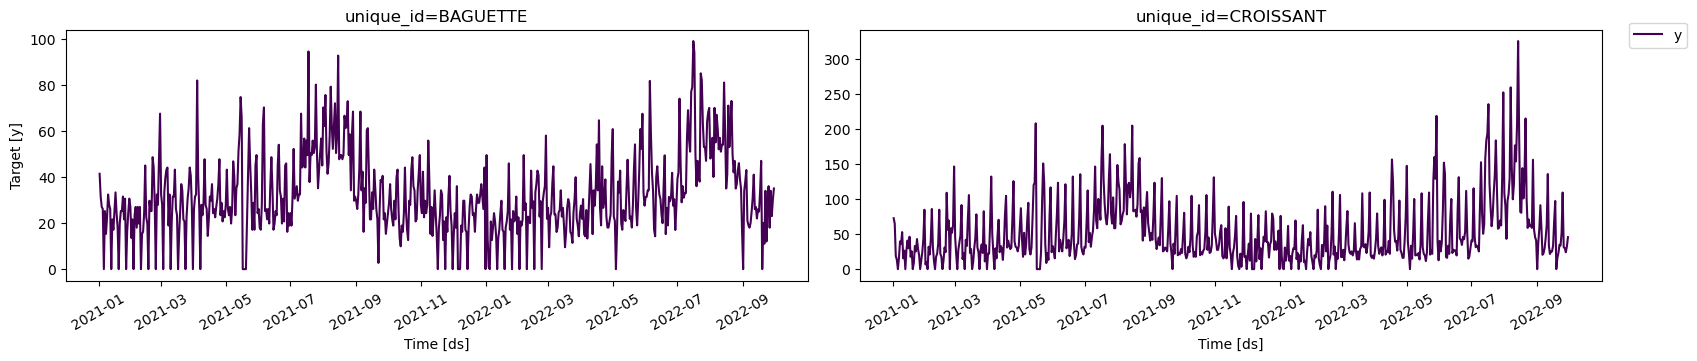

<Figure size 1200x600 with 0 Axes>

In [5]:
# plot the time series for two products
# daily sales for "BAGUETTE" and "CROISSANT"
plt.figure(figsize=(12, 6))
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], palette="viridis")

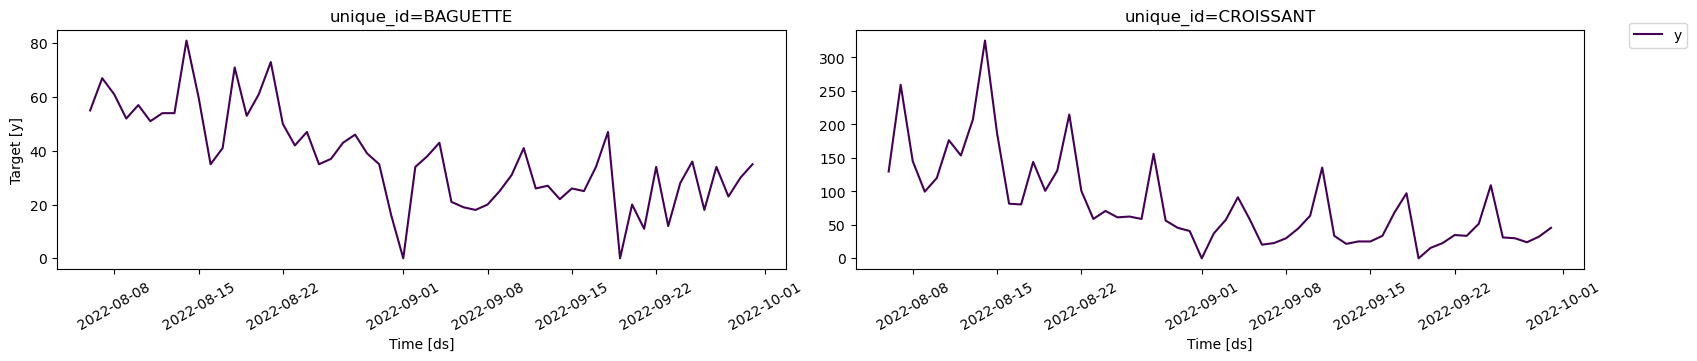

In [6]:
# the library allows us to plot only the last 56 days of the time series (timestamps)
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

## Baseline models

In [7]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [8]:
# define the horizon for forecasting
# we will forecast 7 days ahead
# this is the number of days we want to predict for each time series
horizon = 7

models = [
    Naive(), # simply forecasts the last observed value
    HistoricAverage(), # forecasts the mean of the historical values
    WindowAverage(window_size=7), # forecasts the mean based on the window of the last 7 days
    SeasonalNaive(season_length=7) # forecasts the last observed value from the same day of the week in the previous week
]

# initialize the StatsForecast object with the models and frequency
sf = StatsForecast(models=models, freq="D")
# fit the models to the data
sf.fit(df=df)
# predict the next 7 days for each time series
preds = sf.predict(h=horizon)

In [9]:
# display the predictions
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


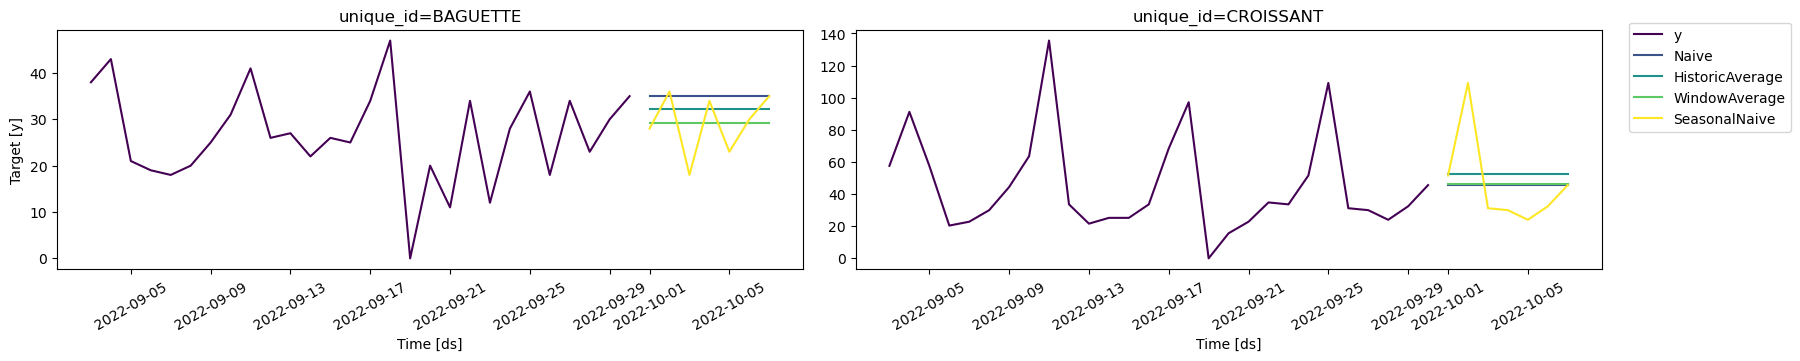

In [10]:
plot_series(
    df=df, 
    forecasts_df=preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")

### Evaluate baseline models

In [11]:
# we will redo the steps above but this time we will split the data into train and test sets
# we will test the models


test = df.groupby("unique_id").tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [13]:
sf.fit(df=train)

preds = sf.predict(h=horizon)

# create the evaluation dataframe
# we will merge the test set with the predictions
# this will allow us to compare the actual values with the predicted values
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [ ]:
evaluation = evaluate(
    eval_df, # this is the dataframe with the actual values and the predictions
    metrics=[mae], # we will use the Mean Absolute Error (MAE) as the evaluation metric
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [15]:
# drop the ` unique_id` column and group by `metric` to get the mean values
# this will give us the average MAE for each model across all time series

evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


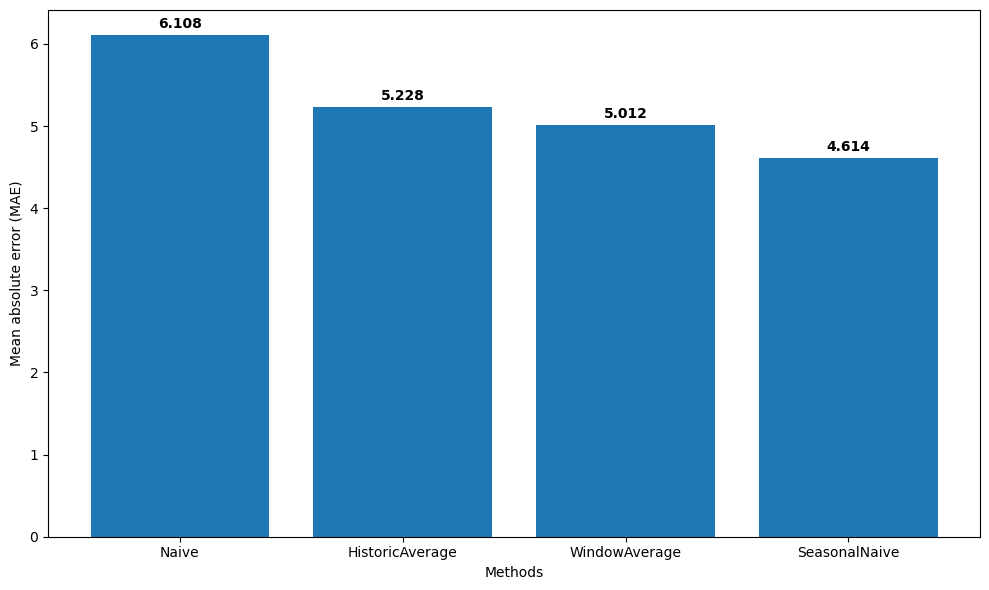

In [18]:
# bar plot of the evaluation results


methods = evaluation.columns[1:].tolist()  
values = evaluation.iloc[0, 1:].tolist() 

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

## AutoARIMA

In [19]:
# we will use the AutoARIMA model for forecasting
# this model automatically selects the best ARIMA parameters for each time series
from statsforecast.models import AutoARIMA


In [21]:
# define a subset of the dataset
unique_ids = ["BAGUETTE", "CROISSANT"]

# if run the prediction on the entire dataset, it will take a long time
# the prediction is done for each series separately, so we can speed it up by using a subset of the data


small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

# with the merge below we can compare the predictions of the baseline models with the ARIMA models
arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353152,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [22]:
# calculate the overall mean absolute error (MAE) for the ARIMA models
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


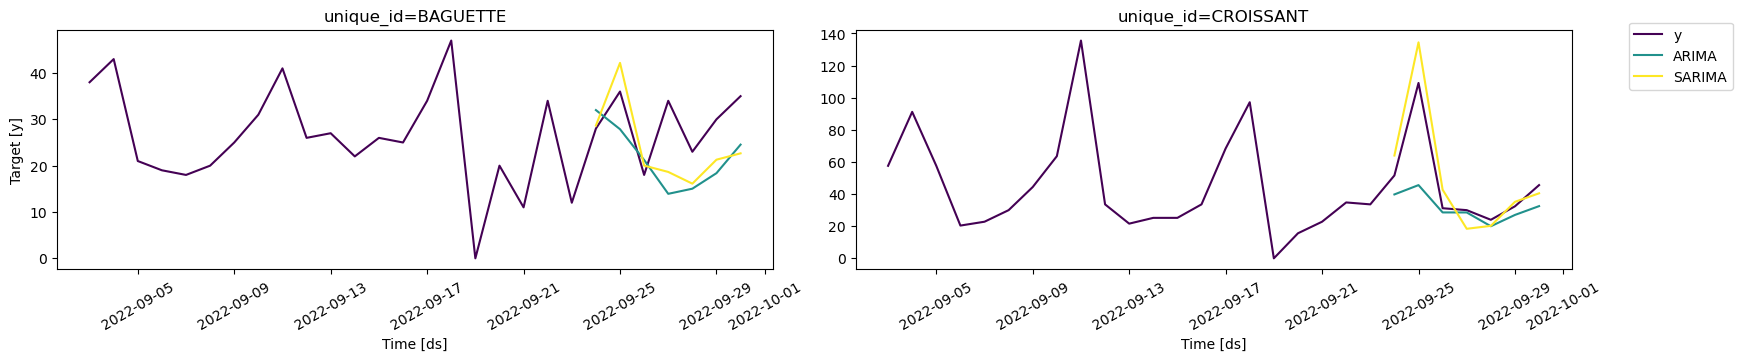

In [23]:
plot_series(
    df=df, 
    forecasts_df=arima_preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")

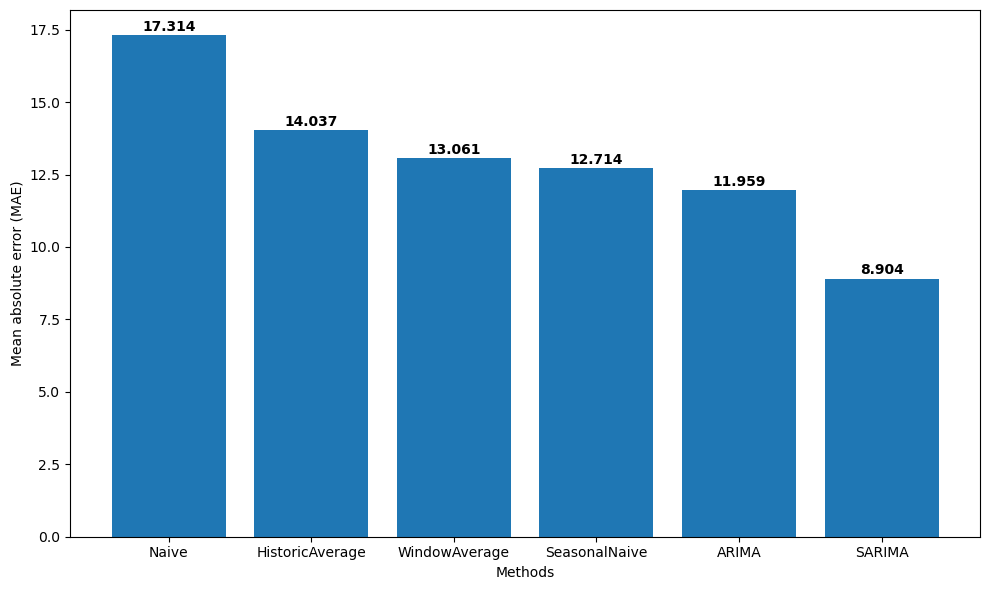

In [24]:
# bar plot of the ARIMA evaluation results
methods = arima_eval.columns[1:].tolist()  
values = arima_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

## Cross-validation

In [25]:
# we will use cross-validation to evaluate the models
# this will allow us to see how the models perform on different subsets of the data
# we will use the same subset of the data as before
small_df = df[df["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=7), # the best baseline model
    AutoARIMA(seasonal=False, alias="ARIMA"), # ARIMA model without seasonality
    AutoARIMA(season_length=7, alias="SARIMA") # SARIMA model with seasonality
]

sf = StatsForecast(models=models, freq="D")


cv_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355196,71.584713
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337980,78.458883
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195002,57.001732
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649013,49.401144
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785876,49.725278


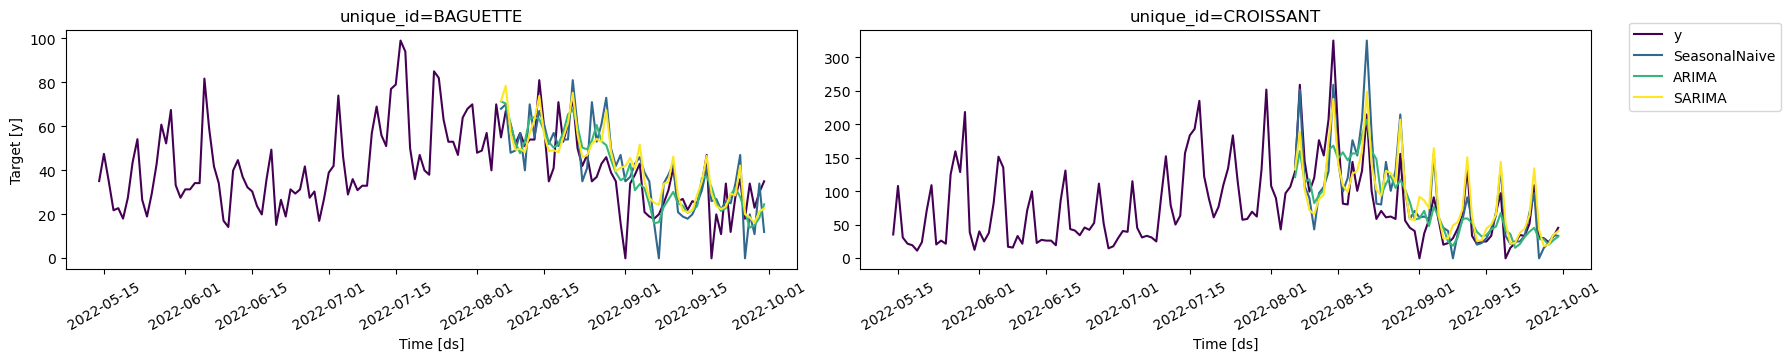

In [26]:
# plot the cross-validation results
plot_series(
    df=small_df, 
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1), 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=140, 
    palette="viridis")

In [27]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.17093,19.281295


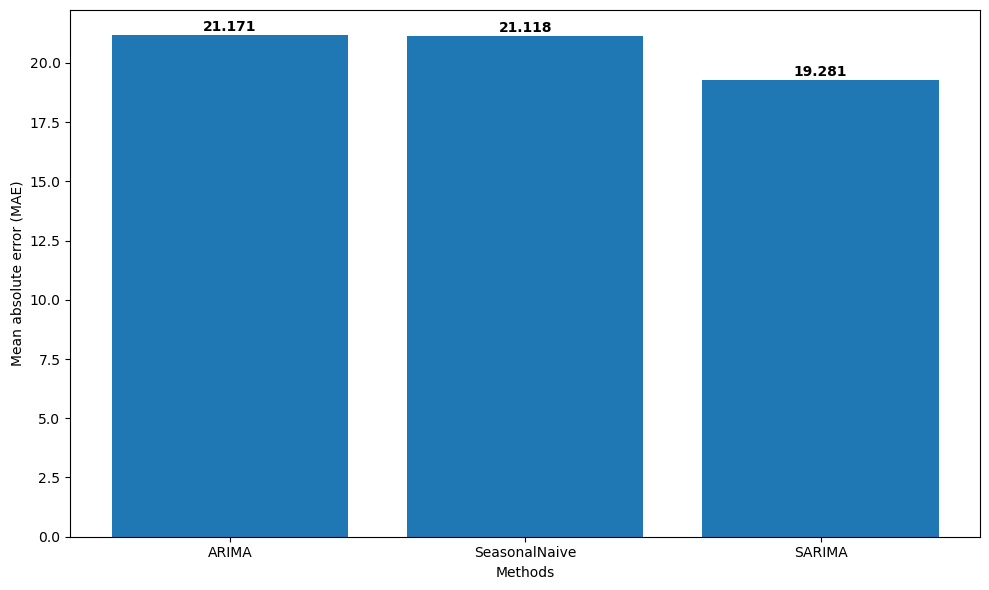

In [28]:
methods = cv_eval.columns[1:].tolist()  
values = cv_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

## Forecasting with exogenous features

In [29]:
# read the dataset again to ensure we have the latest version
df = pd.read_csv("data/daily_sales_french_bakery.csv", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


<Figure size 1200x600 with 0 Axes>

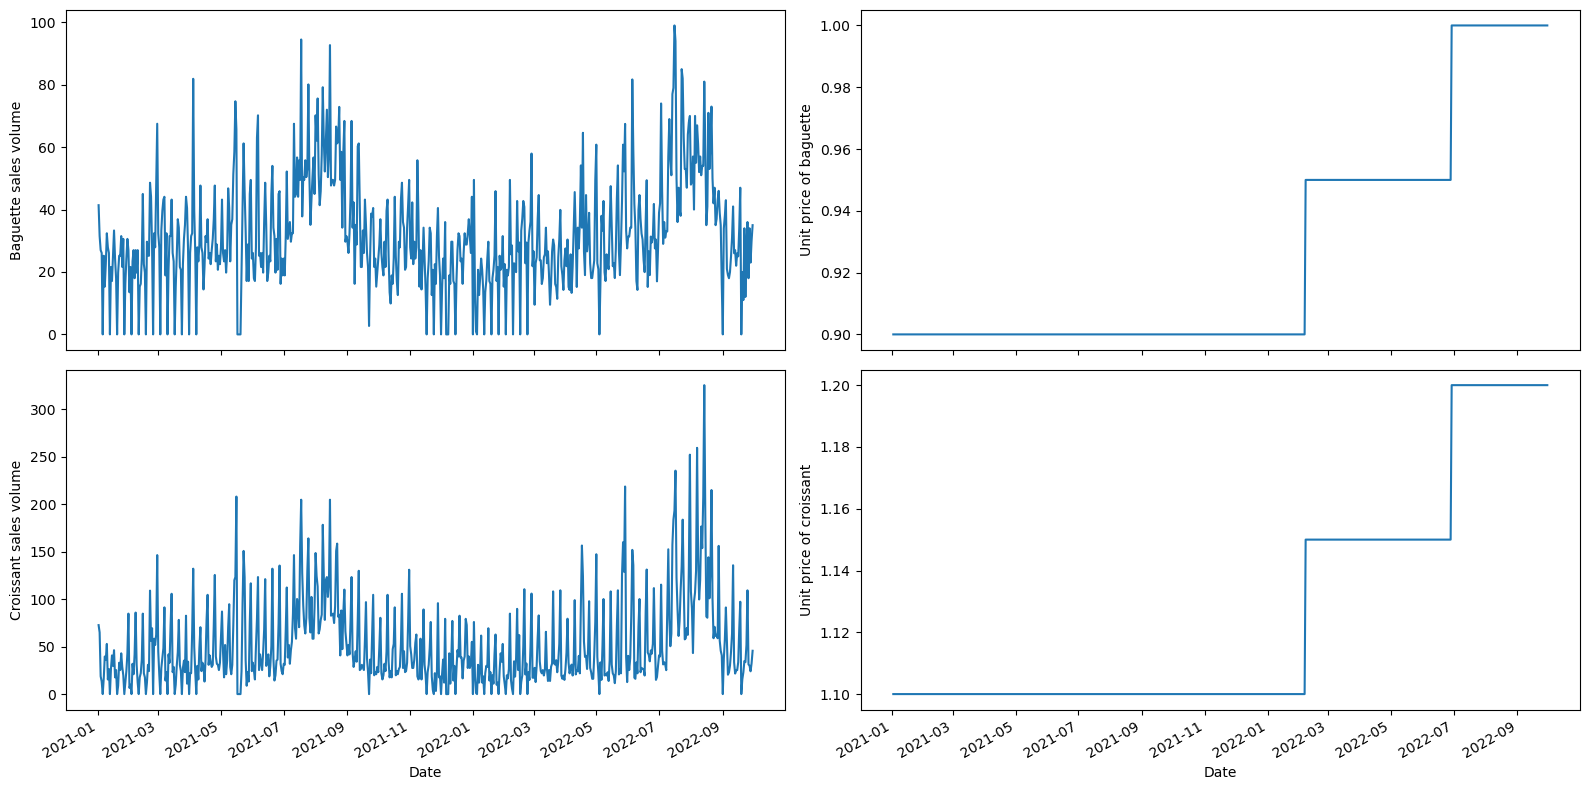

In [30]:
# simple plotting of the time series for "BAGUETTE" and "CROISSANT"
plt.figure(figsize=(12, 6))
baguette_plot_df = df[df["unique_id"] == "BAGUETTE"]
croissant_plot_df = df[df["unique_id"] == "CROISSANT"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

ax1.plot(baguette_plot_df["ds"], baguette_plot_df["y"])
ax1.set_xlabel("Date")
ax1.set_ylabel("Baguette sales volume")

ax2.plot(baguette_plot_df["ds"], baguette_plot_df["unit_price"])
ax2.set_xlabel("Date")
ax2.set_ylabel("Unit price of baguette")

ax3.plot(croissant_plot_df["ds"], croissant_plot_df["y"])
ax3.set_xlabel("Date")
ax3.set_ylabel("Croissant sales volume")

ax4.plot(croissant_plot_df["ds"], croissant_plot_df["unit_price"])
ax4.set_xlabel("Date")
ax4.set_ylabel("Unit price of croissant")

fig.autofmt_xdate()
plt.tight_layout()

In [31]:
# use a subset of the data for training and testing
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [32]:
# you need to drop the `unit_price` column as it is not needed for forecasting
futr_exog_df = test.drop(["y"], axis=1)
futr_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [33]:
# define the models with exogenous variables
# we will use the AutoARIMA model with exogenous variables
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)
arima_exog_preds = sf.predict(h=7, X_df=futr_exog_df)

models = [
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train.drop(["unit_price"], axis=1))
arima_preds = sf.predict(h=horizon)

In [34]:
# merge the predictions with the test set
# this will allow us to compare the predictions of the ARIMA models with the actual values
test_df = test.merge(arima_exog_preds, on=["unique_id", "ds"], how="left")\
              .merge(arima_preds, on=["unique_id", "ds"], how="left")
test_df

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.0,1.0,28.898435,28.657114
1,BAGUETTE,2022-09-25,36.0,1.0,42.512686,42.182373
2,BAGUETTE,2022-09-26,18.0,1.0,20.423196,20.013652
3,BAGUETTE,2022-09-27,34.0,1.0,19.065559,18.646490
4,BAGUETTE,2022-09-28,23.0,1.0,16.468275,16.114924
5,BAGUETTE,2022-09-29,30.0,1.0,21.656139,21.288018
6,BAGUETTE,2022-09-30,35.0,1.0,23.100453,22.660123
7,CROISSANT,2022-09-24,51.6,1.2,64.424685,64.011002
8,CROISSANT,2022-09-25,109.2,1.2,135.123836,134.488202
9,CROISSANT,2022-09-26,31.2,1.2,43.525648,42.735407


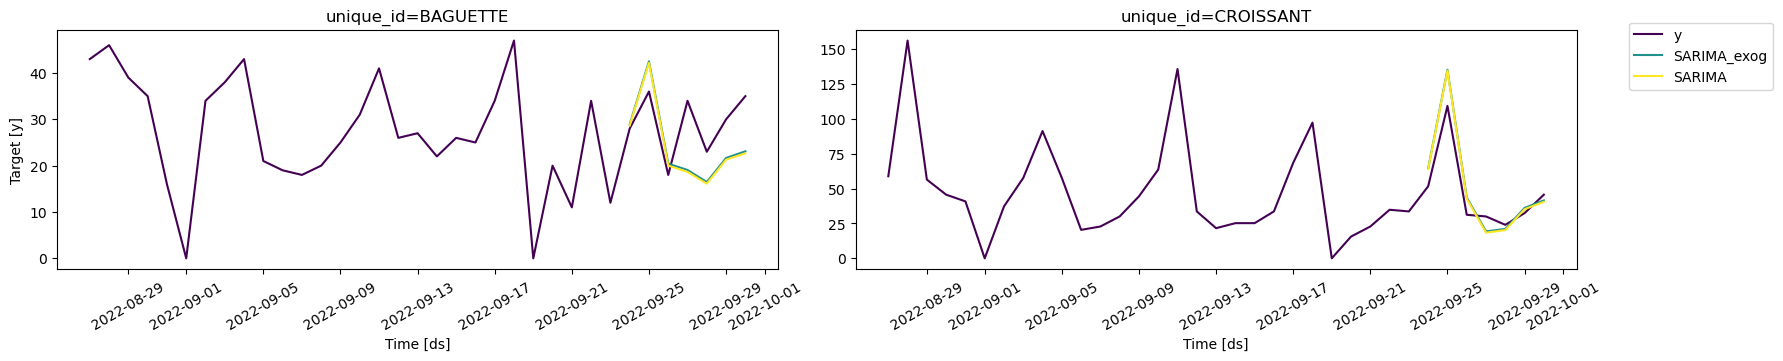

In [35]:
plot_series(
    df=train, 
    forecasts_df=test_df, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28,
    models=["SARIMA_exog", "SARIMA"],
    palette="viridis"
)

In [36]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")

# perform cross-validation with exogenous variables
# this will allow us to see how the models perform on different subsets of the data
# we will use the same subset of the data as before
cv_exog_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_df,
    n_windows=8,
    step_size=7,
    refit=True
)

cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511304
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.457795
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062447
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525561
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485329


In [37]:
cv_exog_eval = evaluate(
    cv_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_exog_eval = cv_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,19.209811


### Creating features from timestamps

Above we had data with timestamp already, but if we don't, we can use the below to create the exogenous seasonality features

In [38]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [39]:
features = [
    partial(fourier, season_length=7, k=2), # Fourier features for weekly seasonality
    partial(time_features, features=["day", "week", "month"])
]

# create the exogenous features for the training and future data
# this will allow us to use the exogenous features in the forecasting models
small_exog_df, futr_exog_df = pipeline(
    df=small_df,
    features=features,
    freq="D",
    h=horizon
)

In [40]:
# display the first few rows of the small exogenous features dataframe
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [41]:
# check the future exogenous features dataframe
# this dataframe contains the exogenous features for the future data
futr_exog_df

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10
5,BAGUETTE,2022-10-06,-0.781828,-0.974931,0.623495,-0.222509,6,40,10
6,BAGUETTE,2022-10-07,-0.000009,-0.000017,1.000000,1.000000,7,40,10
7,CROISSANT,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
8,CROISSANT,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
9,CROISSANT,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10


In [42]:
# run the AutoARIMA model with exogenous variables

models = [
    AutoARIMA(season_length=7, alias="SARIMA_time_exog")
]

sf = StatsForecast(models=models, freq="D")
cv_time_exog_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_exog_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_time_exog_eval = cv_time_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_time_exog_eval

,metric,SARIMA_time_exog
0,mae,19.602069


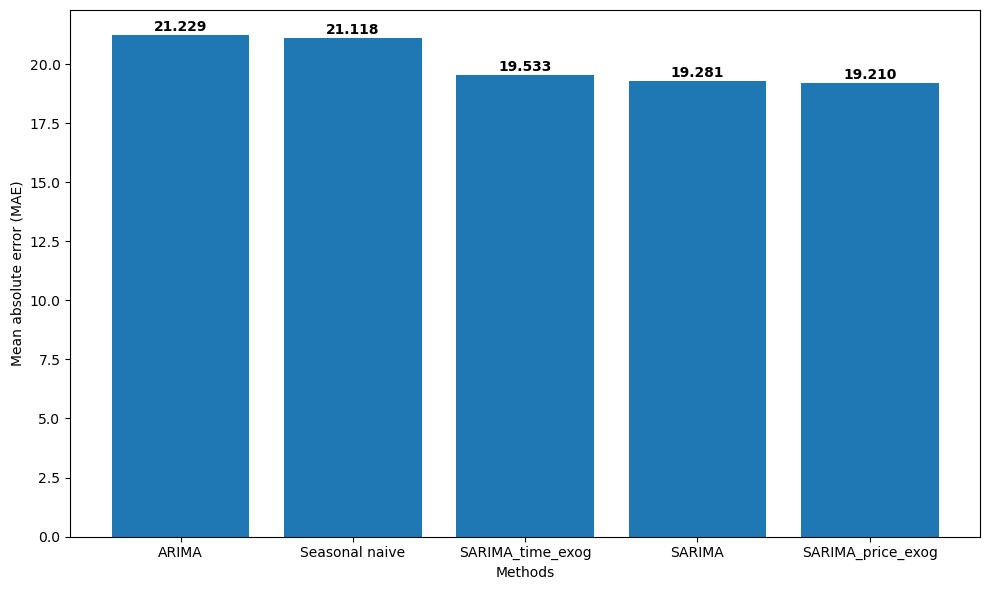

In [43]:
# bar plot of the evaluation results for the models with exogenous variables

# the values below are the mean absolute error (MAE) for each model - filled manually for quick visualization
methods = ["ARIMA", "Seasonal naive", "SARIMA", "SARIMA_price_exog", "SARIMA_time_exog"] 
values = [21.229, 21.118, 19.281, 19.210, 19.533]

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

## Prediction intervals

In [ ]:
# same code as before

unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [45]:
train.head()

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9


In [47]:
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)

# to make the probabilistic predictions, specify the level argument
# here with 80%
prob_preds = sf.predict(h=horizon, X_df=test.drop(["y"], axis=1), level=[80, 90])

In [48]:
test_df = test.merge(prob_preds, on=["unique_id", "ds"], how="left")

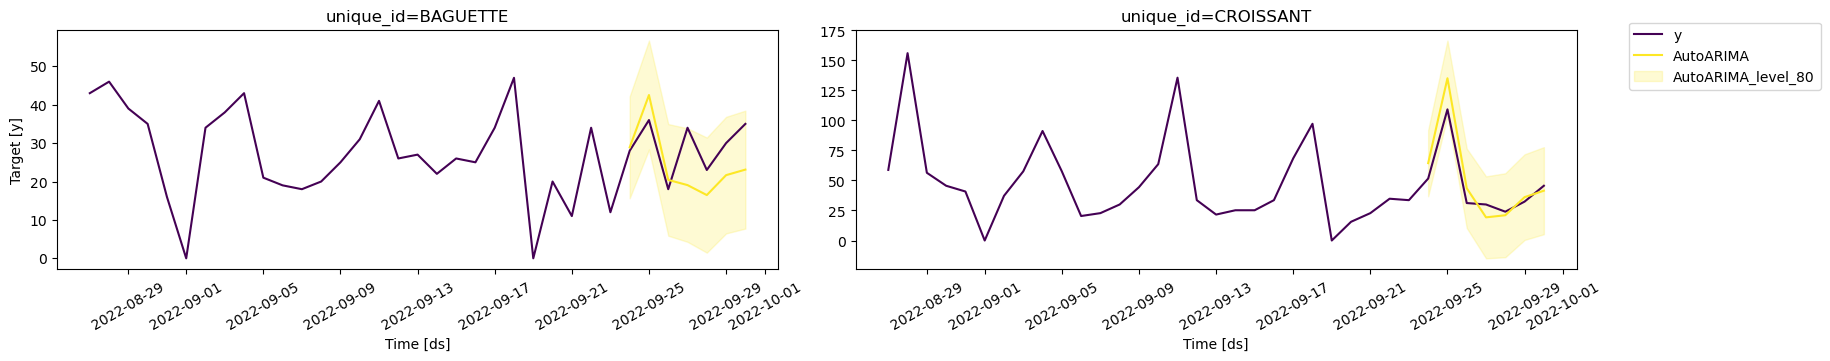

In [49]:
plot_series(
    df=train, 
    forecasts_df=test_df, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28,
    models=["AutoARIMA"],
    level=[80],
    palette="viridis"
)

In [50]:
# running CV with probabilistic predictions
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
cv_prob_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=7,
    refit=True,
    level=[80],
)

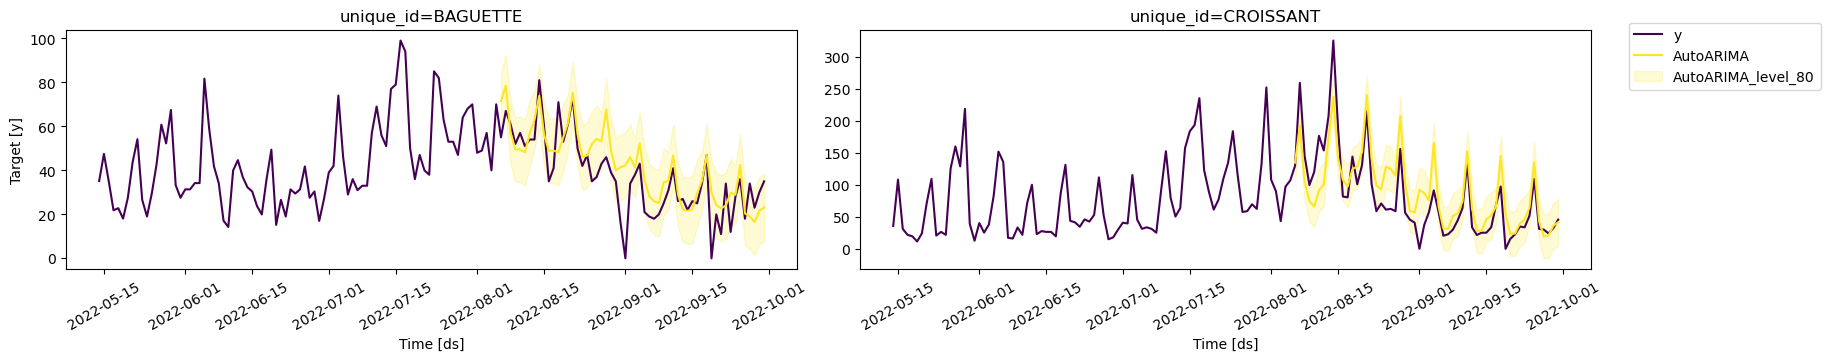

In [51]:
plot_series(
    df=small_df, 
    forecasts_df=cv_prob_df.drop(["y", "cutoff"], axis=1), 
    ids=["BAGUETTE", "CROISSANT"], 
    models=["AutoARIMA"],
    max_insample_length=140,
    level=[80],
    palette="viridis"
)

## Evaluation metrics

**NOTE** When we are using confidency intervals, we need to use more appropriate evaluation metrics. Check [this notebook](./notes_timeseries.ipynb)

In [52]:
# evaluation with intervals
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog"),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
final_cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=7,
    refit=True,
    level=[80],
)

In [53]:
final_cv_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog,SARIMA_exog-lo-80,SARIMA_exog-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511304,58.278985,84.743623,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.457795,64.353855,92.561735,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062447,42.621897,71.502996,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525561,34.847006,64.204116,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485329,34.606488,64.364171,57.0,39.158042,74.841958


In [54]:
# define a temporary test and train dataset
# this is needed for MAE
temp_test = small_df.groupby("unique_id").tail(7*8)
temp_train = small_df.drop(temp_test.index).reset_index(drop=True)

In [55]:
models = ["SARIMA_exog", "SeasonalNaive"]
metrics = [
    mae,
    mse, 
    rmse, 
    mape, 
    smape,
    partial(mase, seasonality=7),
    scaled_crps
]

final_eval = evaluate(
    final_cv_df.drop(["ds", "cutoff"], axis=1),
    metrics=metrics,
    models=models,
    train_df=temp_train,
    level=[80]
)
final_eval = final_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
final_eval

,metric,SARIMA_exog,SeasonalNaive
0,mae,19.209811,21.117857
1,mape,0.328587,0.376819
2,mase,1.181403,1.328592
3,mse,792.614100,970.417143
4,rmse,24.977268,27.875413
5,scaled_crps,0.153619,0.166451
6,smape,0.168229,0.211317


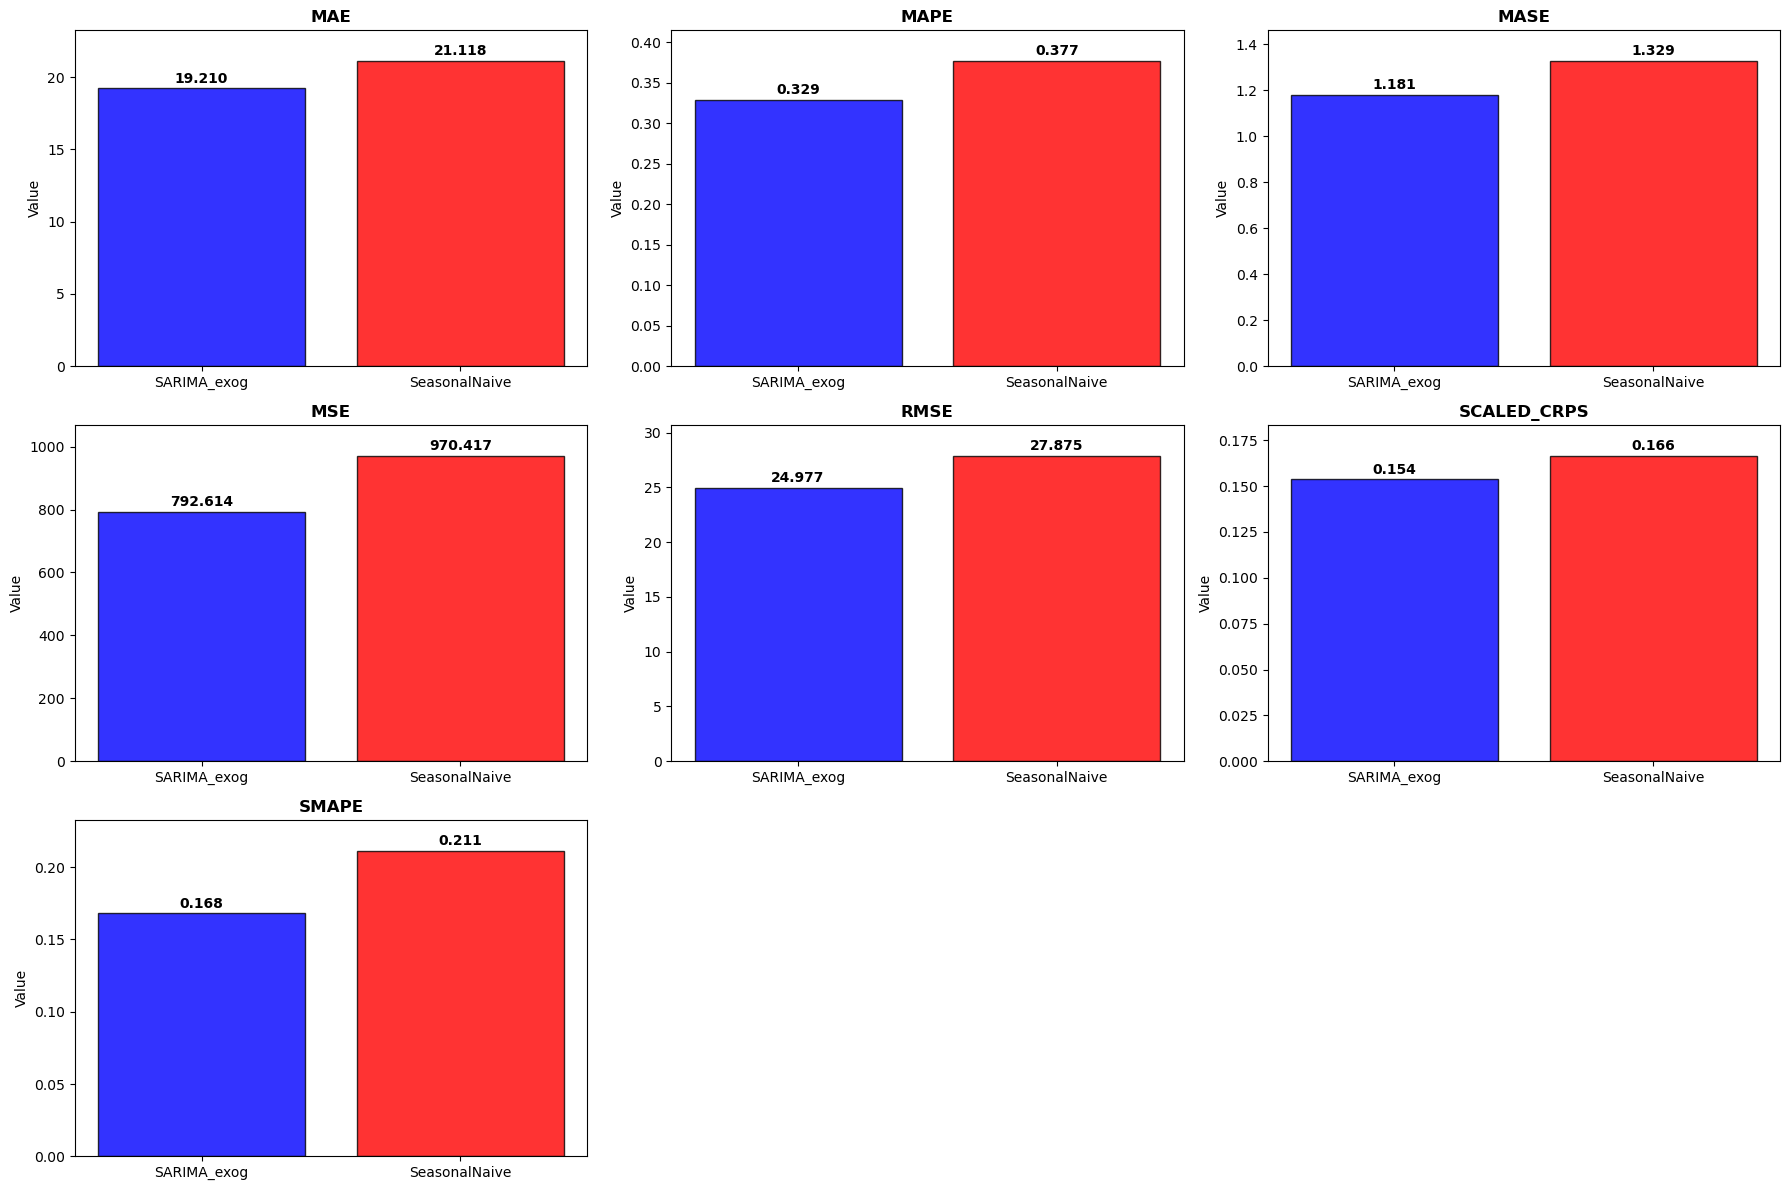

In [56]:
# evaluate using all metrics visually
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

axes_flat = axes.flatten()

models = ['SARIMA_exog', 'SeasonalNaive']
x_pos = [0, 1]
colors = ['blue', 'red']

for i, row in final_eval.iterrows():
    ax = axes_flat[i]
    
    model_values = [row['SARIMA_exog'], row['SeasonalNaive']]
    
    bars = ax.bar(x_pos, model_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    for j, (bar, value) in enumerate(zip(bars, model_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_title(row['metric'].upper(), fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, ha='center')
    ax.set_ylabel('Value')
    max_value = max(model_values)
    ax.set_ylim(0, max_value * 1.1)

fig.delaxes(axes_flat[7])

axes_flat[8].set_visible(False)

plt.tight_layout()
plt.show()